In [1]:
import os
from PIL import Image
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt

import preprocess as p
import architecture as arch
import display as  disp


In [2]:
data_dir = './dataset'
batch_size = 32
img_size = 64
exp_size =(32, 32)
learning_rate = 0.001
num_epochs = 20

#Architecture
out_1 = 64 
out_2 = 128 
out_3 = 256 
out_4 = 512 

#Hiperparams
ARCHT = ["3C", "4C", "B3C"]
LR = [0.001, 0.0001, 0.0002]
DA = ["NO", "DA"]

train_real_dir = os.path.join(data_dir,'train', 'training' ,'REAL')
train_fake_dir = os.path.join(data_dir,'train', 'training' ,'FAKE')
val_real_dir = os.path.join(data_dir,'train', 'validation' ,'REAL')
val_fake_dir = os.path.join(data_dir, 'train' , 'validation', 'FAKE')

In [3]:
print(train_real_dir)
print(train_fake_dir)
print(val_real_dir)
print(val_fake_dir)

./dataset/train/training/REAL
./dataset/train/training/FAKE
./dataset/train/validation/REAL
./dataset/train/validation/FAKE


In [4]:
#Mostrar que la cantidad de imágenes y el tamaño es el correcto
print("_______________TRAINING______________________________")
disp.display_directory_images(exp_size, train_real_dir)
disp.display_directory_images(exp_size, train_fake_dir)
print("_______________VALIDATION______________________________")
disp.display_directory_images(exp_size, val_real_dir)
disp.display_directory_images(exp_size, val_fake_dir)

_______________TRAINING______________________________
IMÁGENES REALES
Error al procesar la imagen ./dataset/train/training/REAL/.ipynb_checkpoints: [Errno 21] Is a directory: '/home/helena/work/TFG1/dataset/train/training/REAL/.ipynb_checkpoints'
El contador de imágenes con resolución distinta a 32x32 en la dirección ./dataset/train/training/REAL es: 0
El contador de imágenes con resolución de 32x32 en la dirección ./dataset/train/training/REAL es: 35000
IMÁGENES FALSAS
Error al procesar la imagen ./dataset/train/training/FAKE/.ipynb_checkpoints: [Errno 21] Is a directory: '/home/helena/work/TFG1/dataset/train/training/FAKE/.ipynb_checkpoints'
El contador de imágenes con resolución distinta a 32x32 en la dirección ./dataset/train/training/FAKE es: 0
El contador de imágenes con resolución de 32x32 en la dirección ./dataset/train/training/FAKE es: 35000
_______________VALIDATION______________________________
IMÁGENES REALES
El contador de imágenes con resolución distinta a 32x32 en la di

In [5]:
#Conseguir la media y desviación del dataset de entrenamiento para la normalización
p.get_media_std_training(data_dir)

Media: tensor([0.4718, 0.4628, 0.4176])
Desviación estándar: tensor([0.2361, 0.2360, 0.2636])


In [3]:
#Crear el train_loader y el validation_loader
train_loader = p.get_train_loader(data_dir, batch_size=batch_size, img_size=img_size)
train_loader_da = p.get_train_loader_da(data_dir, batch_size=batch_size, img_size=img_size)
validation_loader = p.get_validation_loader(data_dir, batch_size=batch_size, img_size=img_size)

In [7]:
'''
Esto es lo que consigues añadiendo un torch.stack a la lista de labels (hay que pasar [labels] porque labels es un solo tensor, en cambio con corchetes es una lista que contiene un tensor)
No entiendo el uso que se le puede dar a esto, lo dejo aquí demostrado y cuando lo hablemos lo meto en el preprocess.py si es necesario
Para acceder a las etiquetas (como ahora el vector tiene forma [1 *dim0*, batch_size *dim1*] deberías acceder a la dimensión 1 (porque la cero es la añadida con el stack) y de ahí coger los valores, o antes de usar el tensor hacer un labels_flat = label_stack.squeeze(0) dejando el vector como [Batch_size] de nuevo 
'''
for images, labels in train_loader:
    labels_stack = torch.stack([labels])
    print("Tamaño del batch de imágenes:", images.shape)  # [batch_size, C, H, W]
    print("Tamaño del batch de etiquetas:", labels.shape)  # [batch_size]
    print(f"Shape del stack de etiquetas: {labels_stack.shape}") # [1, batch_size] ???????
    break

Tamaño del batch de imágenes: torch.Size([32, 3, 64, 64])
Tamaño del batch de etiquetas: torch.Size([32])
Shape del stack de etiquetas: torch.Size([1, 32])


In [8]:
#Comprobar que devuelve bien los datos de training y validación (Se puede cambiar el número de batches mostrados)
print("_____FORMATO train_loader_____")
disp.display_loader(train_loader,1)
print("_____FORMATO validation_loader_____")
disp.display_loader(validation_loader,1)

_____FORMATO train_loader_____
Tamaño del batch de imágenes: torch.Size([32, 3, 64, 64])
Tamaño del batch de etiquetas: torch.Size([32])
Etiquetas del batch: tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 0])
_____FORMATO validation_loader_____
Tamaño del batch de imágenes: torch.Size([32, 3, 64, 64])
Tamaño del batch de etiquetas: torch.Size([32])
Etiquetas del batch: tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 1])


In [9]:
# Obtener los nombres de las clases (etiquetas) en el dataset
class_names = train_loader.dataset.classes  
print("Clases en el dataset train_loader:", class_names)
class_names = validation_loader.dataset.classes  
print("Clases en el dataset validation_loader:", class_names)

Clases en el dataset train_loader: ['FAKE', 'REAL']
Clases en el dataset validation_loader: ['FAKE', 'REAL']


In [10]:
print("DATOS DE ENTRENAMIENTO")
disp.display_labels_loader(train_loader)
print("DATOS DE VALIDACIÓN")
disp.display_labels_loader(validation_loader)

DATOS DE ENTRENAMIENTO
Número de etiquetas fake= 35000
Número de etiquetas reales= 35000
DATOS DE VALIDACIÓN
Número de etiquetas fake= 15000
Número de etiquetas reales= 15000


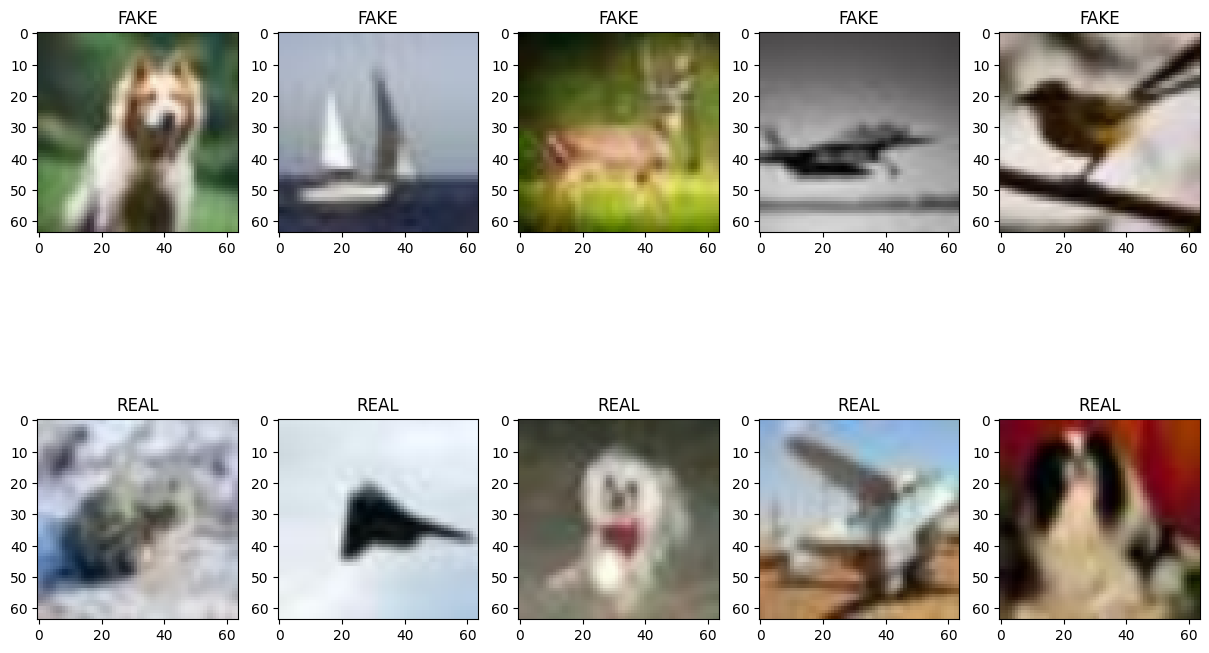

In [11]:
#VISUALIZACIÓN DE LAS IMÁGENES
n_perlabel =5 #Cuántas por fila
n_label=2 #Cuántas columnas

images = disp.filter_images(n_perlabel, train_loader) #Creamos el vector que contiene el número de imágenes especificado, primero fake y luego real (en este caso 5 y 5)
'''
SI QUEREMOS MOSTRAR LAS IMÁGENES DESNORMALIZADAS SOLO COMENTAMOS LA LÏNEA DE ABAJO Y LISTO
'''
#Convertimos  a tensor  la media y la desviación para operar con ellos
mean=torch.tensor([0.4718, 0.4628, 0.4176])
std=torch.tensor([0.2361, 0.2360, 0.2636])
#Como solo queremos operar en el canal (colores), dejamos el batch, width y  height sin tocar y aplicamos la inversa de la normalización,  ya que mean restaba y std dividía
images_desnormalizadas = images * std[None, :, None, None] + mean[None, :, None, None]

disp.display_images(n_label, n_perlabel, images_desnormalizadas) #Mostramos las imágenes poniendo el número de filas y columnas que deseemos y guardamos el archivo

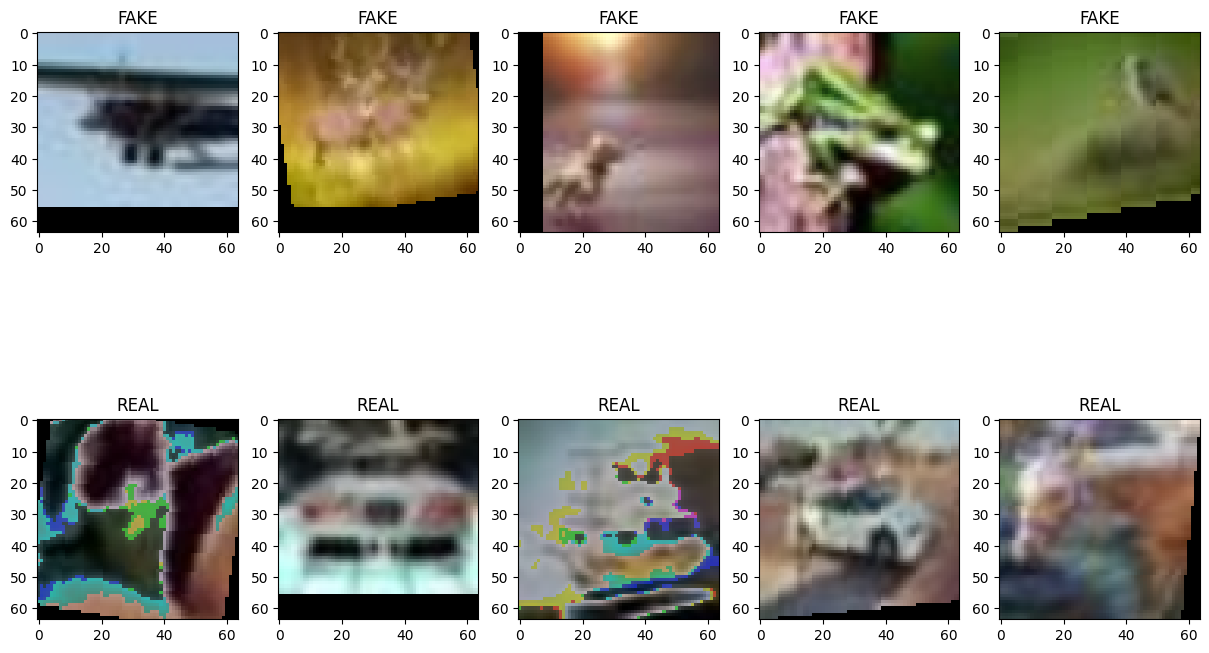

In [4]:
#VISUALIZACIÓN DE LAS IMÁGENES DA
n_perlabel =5 #Cuántas por fila
n_label=2 #Cuántas columnas


images = disp.filter_images(n_perlabel, train_loader_da) #Creamos el vector que contiene el número de imágenes especificado, primero fake y luego real (en este caso 5 y 5)
'''
SI QUEREMOS MOSTRAR LAS IMÁGENES DESNORMALIZADAS SOLO COMENTAMOS LA LÏNEA DE ABAJO Y LISTO
'''
#Convertimos  a tensor  la media y la desviación para operar con ellos
mean=torch.tensor([0.4718, 0.4628, 0.4176])
std=torch.tensor([0.2361, 0.2360, 0.2636])
#Como solo queremos operar en el canal (colores), dejamos el batch, width y  height sin tocar y aplicamos la inversa de la normalización,  ya que mean restaba y std dividía
images_desnormalizadas = images * std[None, :, None, None] + mean[None, :, None, None]

disp.display_images(n_label, n_perlabel, images_desnormalizadas) #Mostramos las imágenes poniendo el número de filas y columnas que deseemos y guardamos el archivo

In [5]:
#Comprobamos GPUs para el entrenamiento
if torch.cuda.is_available():
    print(f"GPUs disponibles: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No hay GPUs disponibles. Se entrenará en CPU.")

GPUs disponibles: 2
GPU 0: NVIDIA GeForce RTX 3090
GPU 1: NVIDIA GeForce RTX 3090


In [15]:
#model = arch.CNN_3C(out_1, out_2, out_3, img_size)
#model = arch.CNN_4C(out_1, out_2, out_3, out_4, img_size)
#model = arch.CNN_B3C(out_1, out_2, out_3, img_size)

In [16]:
#model.load_state_dict(torch.load('Resultados/modelos/Model1_3C_1_NO.pth'))

dummy_input = torch.randn(32, 3, 64, 64) # Entrada de ejemplo para el modelo con tamaño de imagen de 64x64

nombre_modelo = "Show/ModeloB3C_SinPesos.onnx"
try:
    torch.onnx.export(model, dummy_input, nombre_modelo)
    print(f"Modelo exportado correctamente a {nombre_modelo}")
except RuntimeError as e:
    print(f"Error al exportar el modelo: {e}")

Modelo exportado correctamente a Show/ModeloB3C_SinPesos.onnx
